Introduction
--------------

In this section, we cover three additional metrics used in practice for evaluating and choosing between different window functions. 

### Peak Sidelobe Level

As the name suggests, *peak sidelobe level* measures how far down the nearest peak is from the mainlobe's maximum. This captures the worst-case scenario where a nearby signal sits exactly on the highest sidelobe. This idea is illustrated in the next figure.

In [2]:
from scipy import signal 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import abs, arange, array, exp, linspace, log, log10, cos, sin, sqrt, pi
from numpy.fft import fft, fftshift, fftfreq


def db20(W,Nfft=None):
    'Given DFT, return power level in dB or take DFT if need be'
    assert  np.isscalar(W) or W.ndim==1 
    if Nfft is None: # assume W is DFT 
        return 20*log10(abs(W))
    else: # assume time-domain passed, so need DFT
        DFT= fft(array(W).flatten(),Nfft)/np.sqrt(Nfft)
        return 20*log10(abs(DFT.flatten()))

def undb20(x):
    'Invert the db20. Recover amplitude'
    return 10**(x/20.)

D:\Programme\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


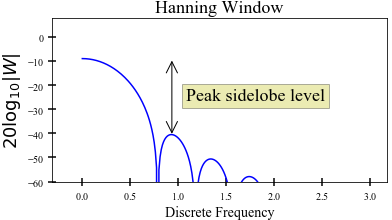

In [3]:
fig, ax = plt.subplots()
fig.set_size_inches((6,3))

Ns= 16
Nf = 256*2
freqs = arange(Nf)*2*pi/Nf
w = signal.windows.hann(Ns,False)
W = db20(w,Nf) 

ax.plot(freqs,W,'-b',ms=4.)
ax.set_ylim(bottom = -60)
ax.set_xlim(right = pi*1.01)
ax.set_xlabel('Discrete Frequency',fontsize=14)
ax.set_ylabel(r'$20\log_{10}|W|$',fontsize=18)
ax.grid()
ax.set_title('Hanning Window',fontsize=18)
ax.annotate('',fontsize=28,
            xy=(76/Nf*2*pi,W[0]),
            xytext=(76/Nf*2*pi,W[0]-32),
            arrowprops={'facecolor':'b','arrowstyle':'<->'},
            )
ax.text( 0.4,0.5,'Peak sidelobe level',
        fontsize=18,
        transform=ax.transAxes,
        bbox={'fc':'y','alpha':.3});

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)

The figure above shows the DFT of the Hanning window and how far down the next sidelobe is from the peak (~31 dB). The figure of merit considers the worst-case where an interfering single frequency sits exactly on the peak of this sidelobe. The next bit of code uses complex roots to find the peaks of the sidelobes for window functions.

In [3]:
def peak_sidelobe(w,N=256,return_index=False, return_all=False):
    '''Given window function, return peak sidelobe level and bin index of 
       all (return_all=True) or some sidelobe peaks if desired (return_index=True). 
       Note that this method fails when the window function
       has no roots on the unit circle (e.g. exponential window). The return index
       is in units of DFT-bin (k/N). 
    '''
    assert (len(w)<=N) # need longer DFT otherwise
    r=np.roots(w)     # find complex roots of window function
    r = r[np.where(np.round(abs(r),3)==1)] # keep only those on unit circle (approx)
    y=log(r).imag/2./pi*N     # get k^th bin index
    y=y[y>0].astype(np.int32) # keep positive half only as integer roundoff
    y=np.unique(y)            # dump repeated
    y.sort()                  # sort in-place 
    W = 20*log10(abs(fft(w,N))) #compute DFT
    # loop through slices and pick out max() as peak for that slice's sidelobe
    sidelobe_levels = []
    sidelobe_idx =[]
    for s in [slice(i,j) for i,j in zip(y[:-1],y[1:])]:
        imx= s.start+W[s].argmax() # bin index of max
        peak= W[imx]-W[0]          # relative to global peak
        sidelobe_levels.append( peak ) # store sidelobe level for later
        sidelobe_idx.append(imx/N)       # ... with corresponding bin
    if return_all:
        return zip(sidelobe_levels, sidelobe_idx)
    if return_index:
        return (sidelobe_levels[0], sidelobe_idx[0])
    return sidelobe_levels[0]

def dftmatrix(N=32,Ns=None):
    'construct DFT matrix of size N give Ns time-samples'
    k= np.arange(N)
    if Ns is None: Ns = N
    n = arange(Ns)
    U = np.matrix(exp(1j* 2*pi/N *k*n[:,None])) # use numpy broadcasting to create matrix
    return U/sqrt(N)


Now, let's consider the scenario with a signal on the highest sidelobe of the window function.

D:\Programme\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


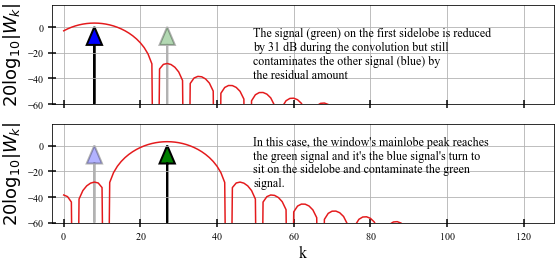

In [7]:
Ns = 64
N= 512

U=dftmatrix(N=N,Ns=Ns)
offset=8 # place DFT near middle of plot for readability
u=array(U[:,offset]).flatten()*sqrt(N) # phase shifts

w = signal.windows.hann(Ns,False)
level,idx = peak_sidelobe(w,N,return_index=True)
x0 = u*np.ones(Ns)
x1=u*exp(1j*2*pi*arange(Ns)*(idx))         # signal on peak of sidelobe

fig,axs = plt.subplots(2,1,sharex=True,sharey=True)
fig.set_size_inches((9,4))

ax=axs[0]
#ax.plot(abs(fft.fft(w*(x0),N)))
ax.plot(db20(w*x0,N))
ax.arrow( offset+idx*N,-60,0,60,
         length_includes_head=True,lw=2.,
         head_length=14,head_width=4,fc='g',alpha=0.3)
#ax.arrow( idx*N,0,0,3,length_includes_head=True,lw=1.5,head_width=2,fc='g')
ax.arrow(offset,-60,0,60,
         length_includes_head=True,
         lw=2.,head_length=14,head_width=4,fc='b')
#ax.legend(loc=0)
ax.set_xlim(right=N/4.,left=-3)
ax.set_ylim(top = 17,bottom=-60)
ax.set_ylabel(r'$20\log_{10}|W_k|$',fontsize=18)
ax.text(0.4,.5,'''The signal (green) on the first sidelobe is reduced 
by 31 dB during the convolution but still 
contaminates the other signal (blue) by 
the residual amount''',va='center',fontsize=12,transform=ax.transAxes);

ax=axs[1]
ax.plot(db20(w*x1,N))
ax.arrow( offset+idx*N,-60,0,60,length_includes_head=True,lw=2.,head_length=14,head_width=4,fc='g')
ax.arrow( offset,-60,0,60,length_includes_head=True,lw=2.,head_length=14,head_width=4,fc='b',alpha=0.3)
#ax.legend(loc=0)
ax.set_xlim(right=N/4.,left=-3)
ax.set_ylim(top = 17,bottom=-60)
ax.set_ylabel(r'$20\log_{10}|W_k|$',fontsize=18)
ax.set_xlabel('k',fontsize=16)
ax.text(0.4,.6,'''In this case, the window's mainlobe peak reaches 
the green signal and it's the blue signal's turn to 
sit on the sidelobe and contaminate the green 
signal.''',va='center',fontsize=12,transform=ax.transAxes);

The cartoon above shows the DFT of the window function as it slides across the two signals for the circular convolution. In the top plot, the green signal sits on the peak of the first sidelobe of the window. Because the peak sidelobe level is 31 dB down, its contribution to the overall DFT at that discrete frequency is reduced by 31 dB. Note that at this stage, the signal on the left offers its maximum contribution because it is squarely on the peak of the window's mainlobe. As shown in the bottom plot, the same situation   happens again  in the convolution as the sliding window reaches the green signal on the right; it will be contaminated by  signal on the left as that signal climbs onto the peak of the sidelobe.

### 3-dB Bandwidth

At the 3-dB bandwidth point, the mainlobe has lost half of its peak power. This is because $10 \log_{10}(1/2) \approx -3 $. The following figure shows the DFT for the  hamming  window and its corresponding half-power point down the mainlobe. In general,  there is no closed form solution to the half-power level so we  must compute it numerically.

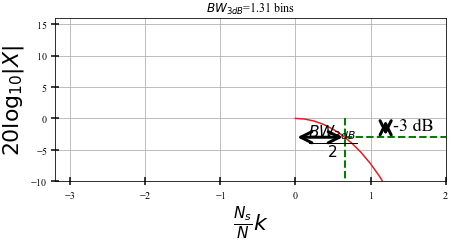

In [5]:
fig,ax = plt.subplots()
fig.set_size_inches((7,3))

N=512
w=signal.windows.hamming(Ns)
W=db20(w,N)

m =10
p=np.polyfit(arange(m)/N*Ns,W[:m]-W[0]+3.01,2) # fit quadratic polynomial
width = np.roots(p)[0]*2 # 3-dB beamwidth

ax.plot(arange(N)/N*Ns,W-W[0]) # normalize to peak
ax.set_ylim(bottom=-10)
ax.set_xlim(right = 2)

ax.vlines(width/2,0,-60,lw=2.,linestyle='--',color='g')
ax.set_ylabel(r'$20\log_{10}|X|$',fontsize=22)
ax.set_title(r'$ BW_{3dB}$=%3.2f bins'%width)
ax.set_xlabel(r'$\frac{N_s}{N} k$',fontsize=22)
ax.annotate('',fontsize=28,xy=(0,-3), 
            xytext=(width/2,-3),
            arrowprops=dict(arrowstyle="<->",lw=3))
ax.annotate('',fontsize=28,xy=(1.2,0), 
            xytext=(1.2,-3),
            arrowprops=dict(arrowstyle="<->",lw=3))
ax.hlines(-3,width/2,2,linestyle='--',color='g',lw=2.)
ax.text( width/2/4,-5,r'$\frac{BW_{3dB}}{2}$',fontsize=22)
ax.text( 1.3,-2,'-3 dB',fontsize=18);

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


The figure above is the schematic for the mainlobe of the window. This figure of merit provides a sense of how far off a signal can be from the mainlobe before losing half its power.

### Scalloping Loss

The DFT divides the sampling frequency $ f_s $ into $N$ discrete frequencies, but the signal of interest may no conveniently lie on one of these sampled frequencies. The *scalloping loss* accounts for the reduction in signal energy due to this common, unfortunate situation. 

One common way to define  the scalloping loss is as the ratio of coherent gain for a tone located half a bin from a DFT sample point to the coherent gain,

$$ Scalloping \hspace{0.1em} Loss = \frac{|\sum_{n=0}^{N_s-1} w_n \exp \left( -j\pi n/N_s  \right)|}{\sum_{n=0}^{N_s-1} w_n} $$

D:\Programme\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


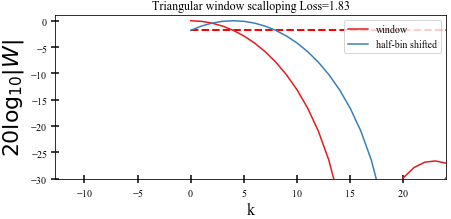

In [6]:
fig,ax = plt.subplots()
fig.set_size_inches((7,3))

N=256
Ns = 32
w=signal.windows.triang(Ns)
W=db20(w,N)

W0 = db20(exp(1j*2*pi/Ns*arange(Ns)*1/2.)*w,N)-W[0]
W=W-W[0] # rescale for plot

ax.plot(W,label='window')
ax.plot(W0,label='half-bin shifted')
scalloping_loss = W[0]-W0[0]
ax.axis(ymin=-30,ymax=1,xmax=24)

ax.set_title('Triangular window scalloping Loss=%3.2f'%(scalloping_loss))
ax.set_xlabel('k',fontsize=16)
ax.set_ylabel(r'$20\log_{10}|W|$',fontsize=22)
ax.hlines(-scalloping_loss,0,24,color='red',linestyle='--',lw=2.)
ax.legend(loc=0)
ax.grid()

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


The horizontal line in the figure above shows the level of the scalloping loss for the triangular window.

## Summary

In this section, we illustrated the major issues involved in using window functions for spectral analysis and derived the most common figures of merit for some popular windows. There are many more windows available and Harris (1978) provides an exhaustive list and many more detailed figures of merit. In fact, I have seen rumpled versions of this 1978 paper in just about every engineering lab I have worked in. In practice, some window functions are preferred because they have coefficients that are easy to implement on fixed point arithmetic hardware without excessive sensitivity to quantization errors. The main idea is that windows with favorable  sidelobe levels are always wider (larger equivalent noise bandwidth and 3-dB bandwidth) so these pull in more signal noise into their wider mainlobes and make it harder to distinguish nearby signals which may fit into the same mainlobe. Thus, there is a trade-off between signal-to-noise (more noise in mainlobe reduces signal-to-noise) and resolution (nearby indistinguishable signals). Unfortunately, it is not possible to simultaneously have very low sidelobes and a very narrow mainlobe. This is due to the *stuffed mattress effect* where "pushing" down the DFT at any one place causes it to sprout up somewhere else.

Outside of two-tone seperability, there is the issue of wideband signals. In that case, you may prefer a wide mainlobe that encompasses the signal bandwidth with very low sidelobes that reduce extraneous signals. The bottom line is that there are many engineering trade-offs involved in choosing window functions for particular application. Understanding how window functions are used in spectral analysis is fundamental to the entire field of signal processing because it touches all of the key engineering problems encountered in practice.

As usual, the corresponding IPython notebook for this post  is available for download [here](https://github.com/unpingco/Python-for-Signal-Processing/blob/master/Windowing_Part3.ipynb). 

Comments and corrections welcome!

References
---------------

* Harris, Fredric J. "On the use of windows for harmonic analysis with the discrete Fourier transform." Proceedings of the IEEE 66.1 (1978): 51-83.